In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from helpers import create_df, get_peaks_and_valleys, plot_df, get_num_reps, smooth_and_resample

In [42]:
# 0 = bicep curl, 1 = shoulder press, 2 = row, 3 = rdl, 4 = squat 
training_files = {"../data2/bicep_curl/bicep_adam_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_mike_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_udai_set1_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv": 1,
                  "../data2/row/row_adam_set1_reps10_1.csv": 2, 
                  "../data2/row/row_andrew_set1_reps10_1.csv": 2, 
                  "../data2/row/row_anuj_set1_rep10_1.csv": 2, 
                  "../data2/row/row_jake_set1_reps12_1.csv": 2, 
                  "../data2/row/row_kamyar_set1_reps10_1.csv": 2, 
                  "../data2/row/row_mike_set1_reps10_1.csv": 2, 
                  "../data2/row/row_suzan_set1_reps10_1.csv": 2, 
                  "../data2/row/row_udai_set1_reps12_1.csv": 2, 
                  "../data2/dead/dead_adam_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_andrew_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_anuj_set1_rep10_1.csv": 3, 
                  "../data2/dead/dead_kamyar_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_mike_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_adam_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_andrew_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_anuj_set1_rep10_1.csv": 4, 
                  "../data2/squat/squat_jake_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_kamyar_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_mike_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_suzan_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_udai_set1_reps10_1.csv": 4,
                  "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv": 1, 
                #   "../data2/row/row_udai_set3_reps10_1.csv": 2, 
                #   "../data2/dead/dead_udai_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_udai_set3_reps10_1.csv": 4,
                  "../data2/newDead/newdead_udai_set1_reps10_1.csv": 3,
                  "../data2/newDead/newdead_udai_set2_reps10_1.csv": 3} 
train_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3] 

test_files = {"../data2/bicep_curl/bicep_adam_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv": 0, 
              "../data2/bicep_curl/bicep_jake_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_kamyar_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_mike_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_suzan_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_udai_set2_reps10_1.csv": 0, 
              "../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_anuj_set2_rep10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_kamyar_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_mike_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set4_reps10_1.csv": 1,
              "../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv": 1, 
              "../data2/row/row_adam_set2_reps10_1.csv": 2, 
              "../data2/row/row_andrew_set2_reps10_1.csv": 2, 
              "../data2/row/row_anuj_set2_rep10_1.csv": 2, 
              "../data2/row/row_jake_set2_reps12_1.csv": 2, 
              "../data2/row/row_kamyar_set2_reps10_1.csv": 2, 
              "../data2/row/row_mike_set2_reps10_1.csv": 2, 
              "../data2/row/row_suzan_set2_reps12_1.csv": 2, 
              "../data2/row/row_udai_set2_reps12_1.csv": 2, 
              "../data2/dead/dead_adam_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_andrew_set2_reps10_1.csv": 3,
              "../data2/dead/dead_anuj_set2_rep10_1.csv": 3, 
              "../data2/dead/dead_kamyar_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_mike_set2_reps10_1.csv": 3, 
              "../data2/squat/squat_adam_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_andrew_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_anuj_set2_rep10_1.csv": 4, 
              "../data2/squat/squat_jake_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_kamyar_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_mike_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_suzan_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_udai_set2_reps10_1.csv": 4,
              } 

test_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3]

../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     304079   -0.834    3.319    9.444   0.098  -0.054   0.012
1     304082   -0.824    3.326    9.452   0.098  -0.054   0.012
2     304085   -0.824    3.326    9.452   0.097  -0.053   0.012
3     304089   -0.824    3.326    9.452   0.097  -0.053   0.012
4     304110   -0.846    3.269    9.446   0.122  -0.056   0.007


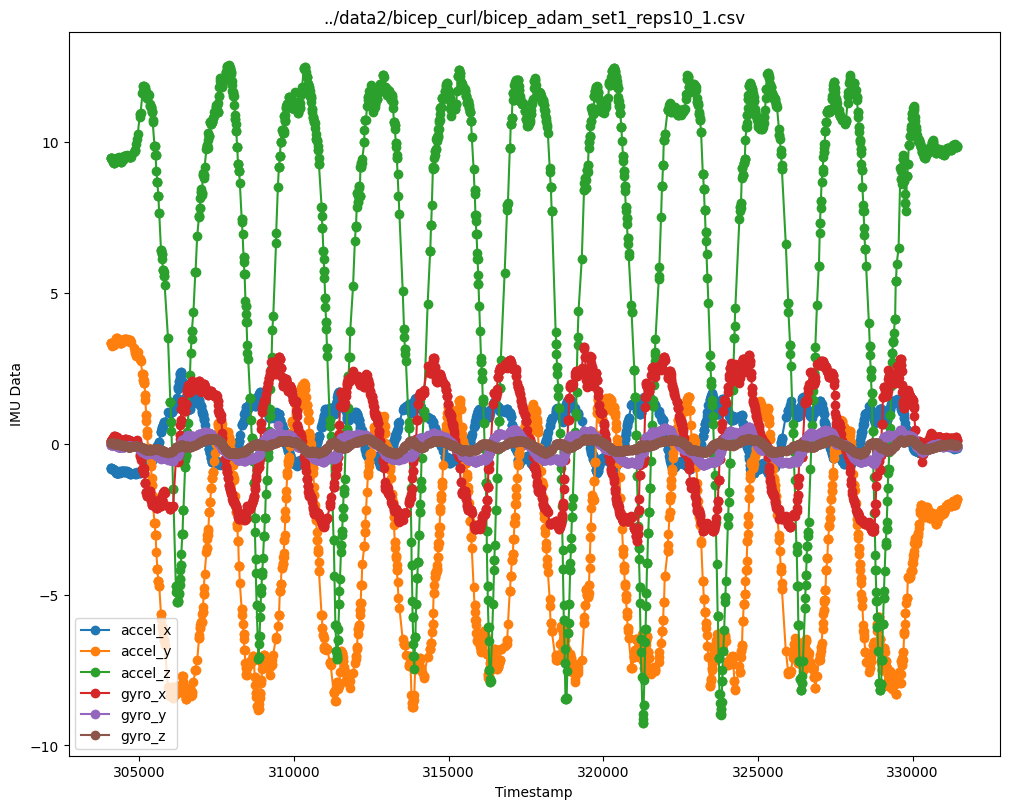

In [43]:
file = "../data2/bicep_curl/bicep_adam_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, file)

In [44]:
def segment_df(df, seconds=5):
    dfs = []
    first = df["timestamp"].iloc[0]
    last = df["timestamp"].iloc[-1]
    total_ms = last - first
    total_secs = total_ms / 1000
    num_intervals = int(total_secs // seconds)
    n = df.shape[0]
    # print(f"n: {n}")
    cutoffs = [first]
    for _ in range(num_intervals + 1):
        cutoffs.append(cutoffs[-1] + (seconds*1000))
    cutoffs = cutoffs[1:]
    # print(f"first: {first}")
    # print(f"cutoffs: {cutoffs}")

    dfs = []
    curr = []
    curr_cutoff_idx = 0
    df = df.reset_index()
    for _, row in df.iterrows():
        if row["timestamp"] > cutoffs[curr_cutoff_idx]:
            if len(curr) > 0:
                curr_df = pd.DataFrame(curr)
                if 'index' in curr_df: 
                    curr_df = curr_df.drop('index', axis=1)
                # print(curr_df.head())
                dfs.append(curr_df)
                curr = []
                # print(f"passed cutoff: {cutoffs[curr_cutoff_idx]}")
            curr_cutoff_idx += 1
            
        else:
            curr.append(row)
            
    if len(curr) > 0:
        curr_df = pd.DataFrame(curr)
        if 'index' in curr_df:
            curr_df = curr_df.drop('index', axis=1)
        # print(curr_df.head())
        # print("last segment")
        dfs.append(curr_df)
    
    # print(dfs)
    return dfs

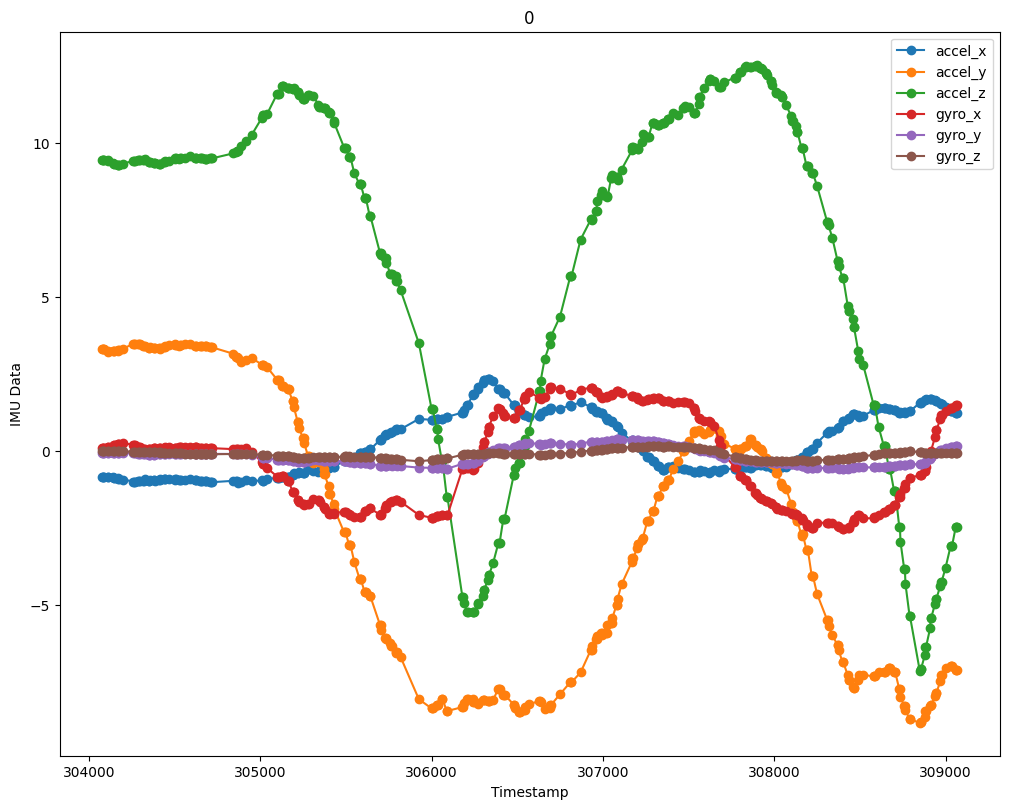

       timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z
0  304080.485714 -0.834743  3.314914  9.444400  0.100286 -0.054400  0.011571
1  304098.989610 -0.833717  3.292104  9.448174  0.110169 -0.055003  0.009475
2  304144.794805 -0.856803  3.257210  9.334535  0.197436 -0.049197  0.001922
3  304175.135065 -0.889366  3.279566  9.300855  0.243184 -0.049423 -0.003743
4  304267.444156 -0.994003  3.502016  9.429400  0.214322 -0.073865 -0.013444


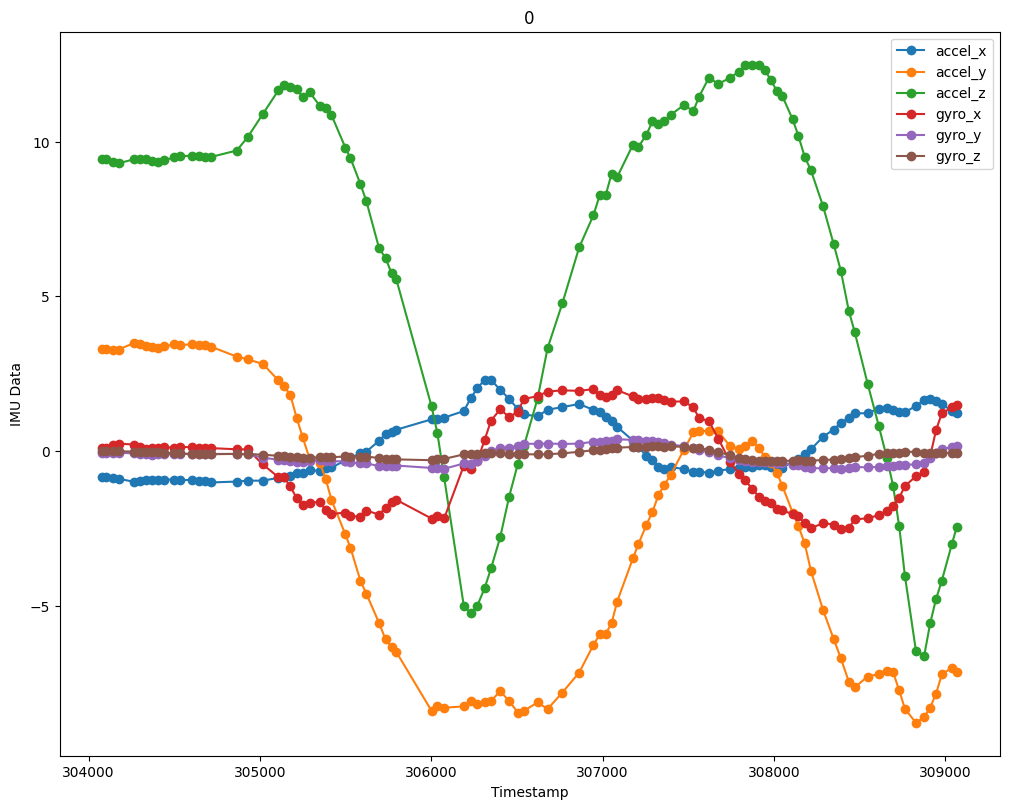

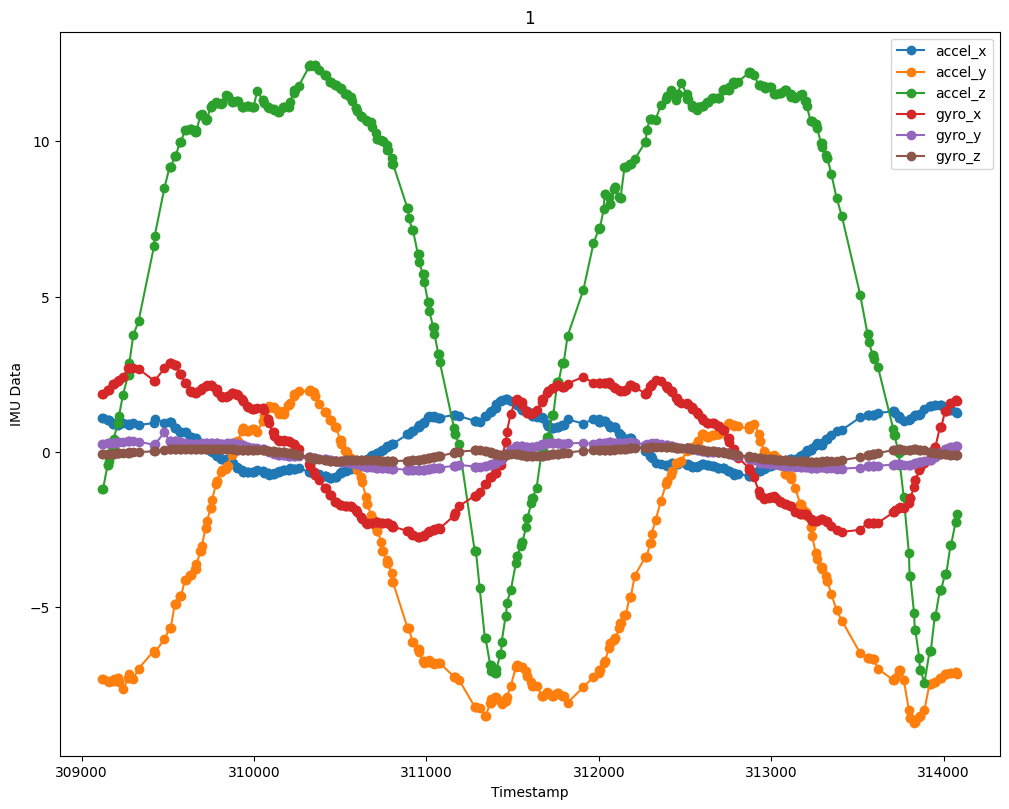

       timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z
0  309116.771429  1.110457 -7.314600 -1.289829  1.826429  0.238143 -0.064857
1  309160.073593  0.996124 -7.398691 -0.256433  2.026171  0.273975 -0.064777
2  309198.087157  0.891272 -7.317980  0.644602  2.226994  0.297528 -0.057540
3  309248.183550  0.898920 -7.484814  1.986368  2.507568  0.320066 -0.041208
4  309297.594517  0.879978 -7.215349  3.560014  2.720826  0.330634 -0.020887


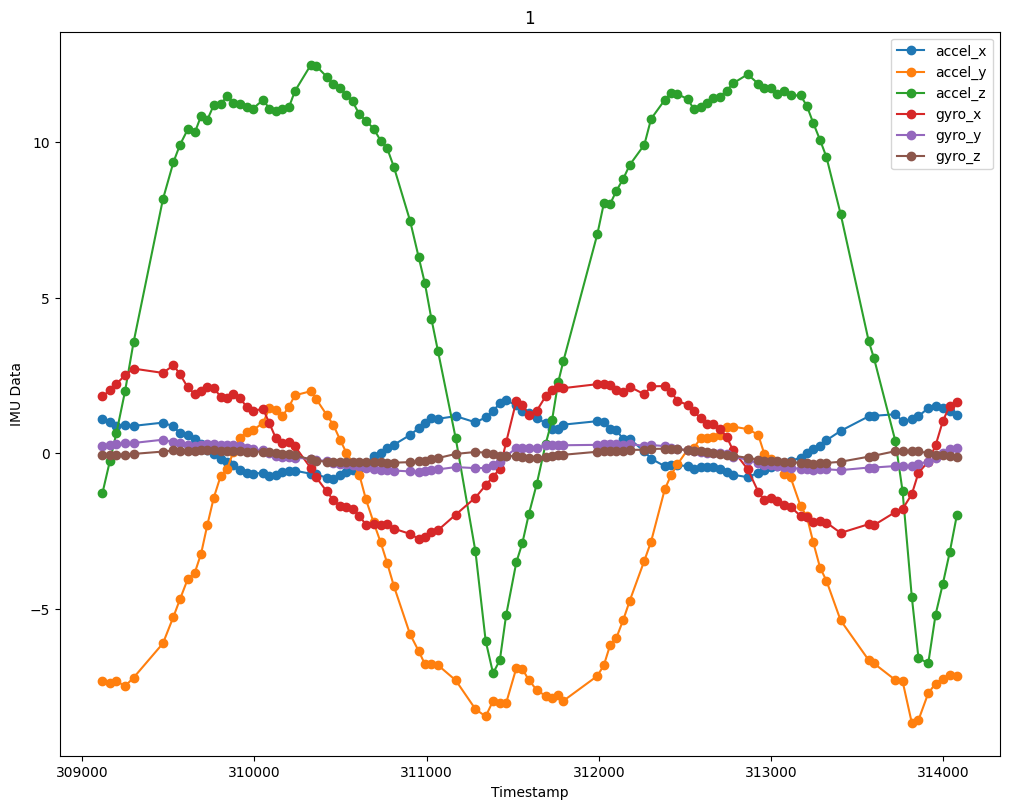

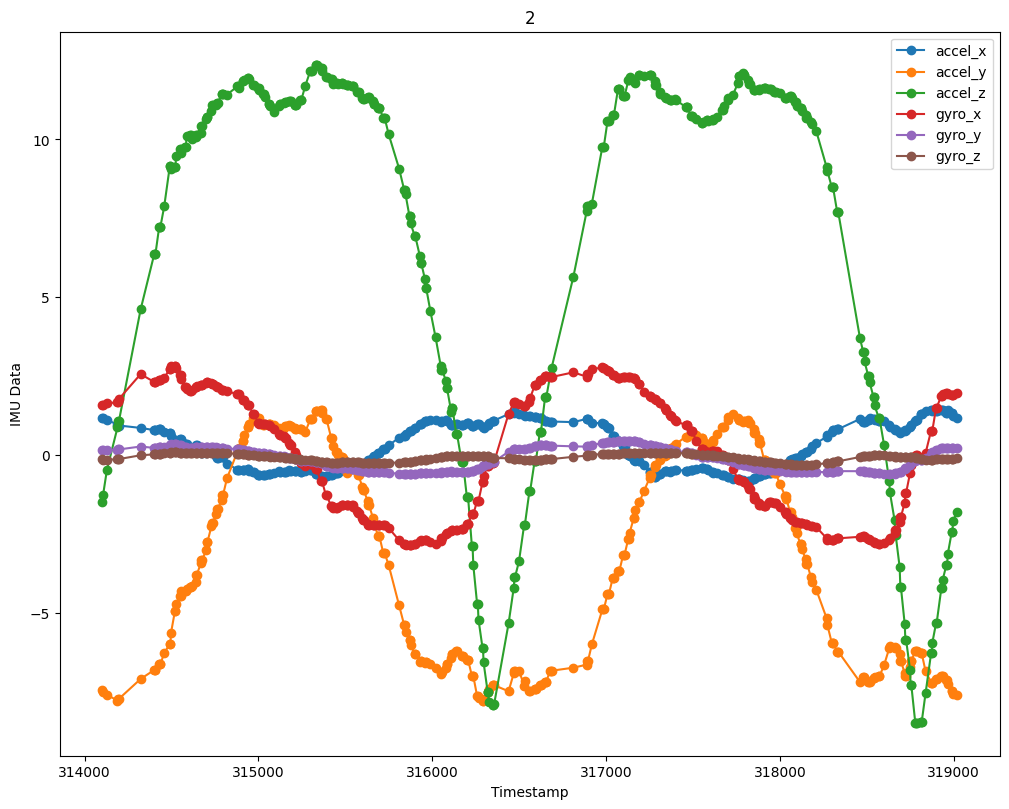

       timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z
0  314096.171429  1.200057 -7.402486 -1.616514  1.570086  0.169400 -0.129400
1  314184.107937  0.962548 -7.766026  0.786942  1.653051  0.179413 -0.128426
2  314398.114286  0.801244 -6.801448  6.306946  2.389927  0.244435  0.035912
3  314432.970563  0.834036 -6.616065  7.259899  2.384777  0.249535  0.054660
4  314492.392208  0.696715 -5.945457  9.178309  2.771132  0.337133  0.092241


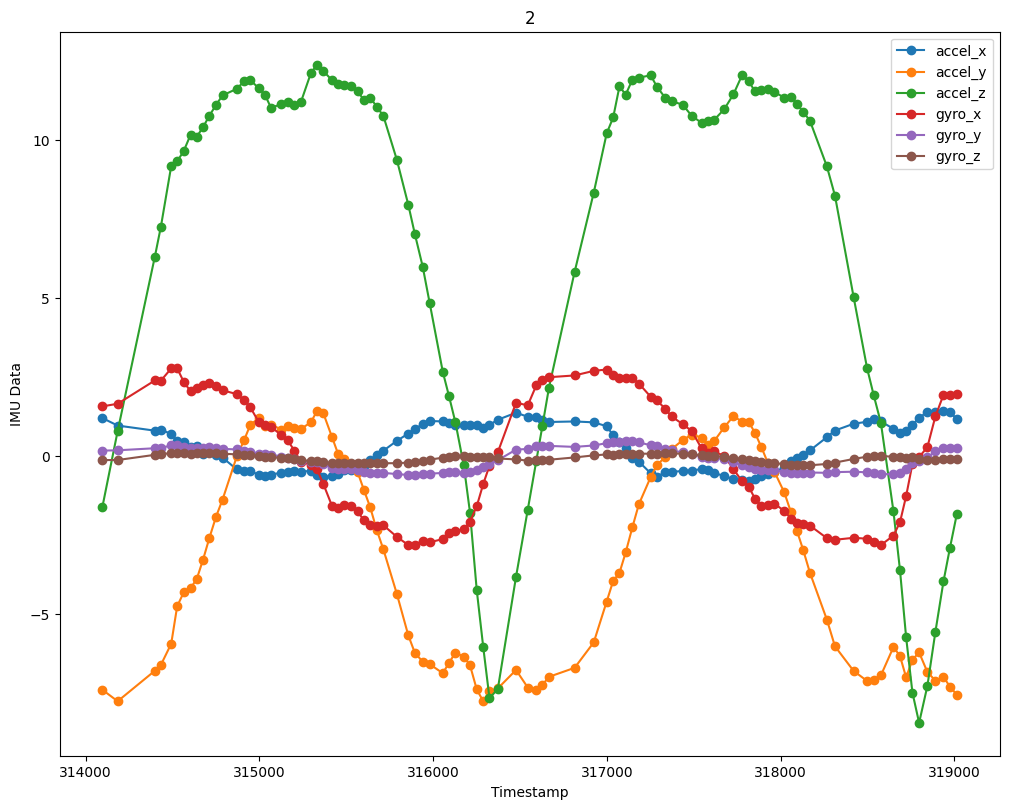

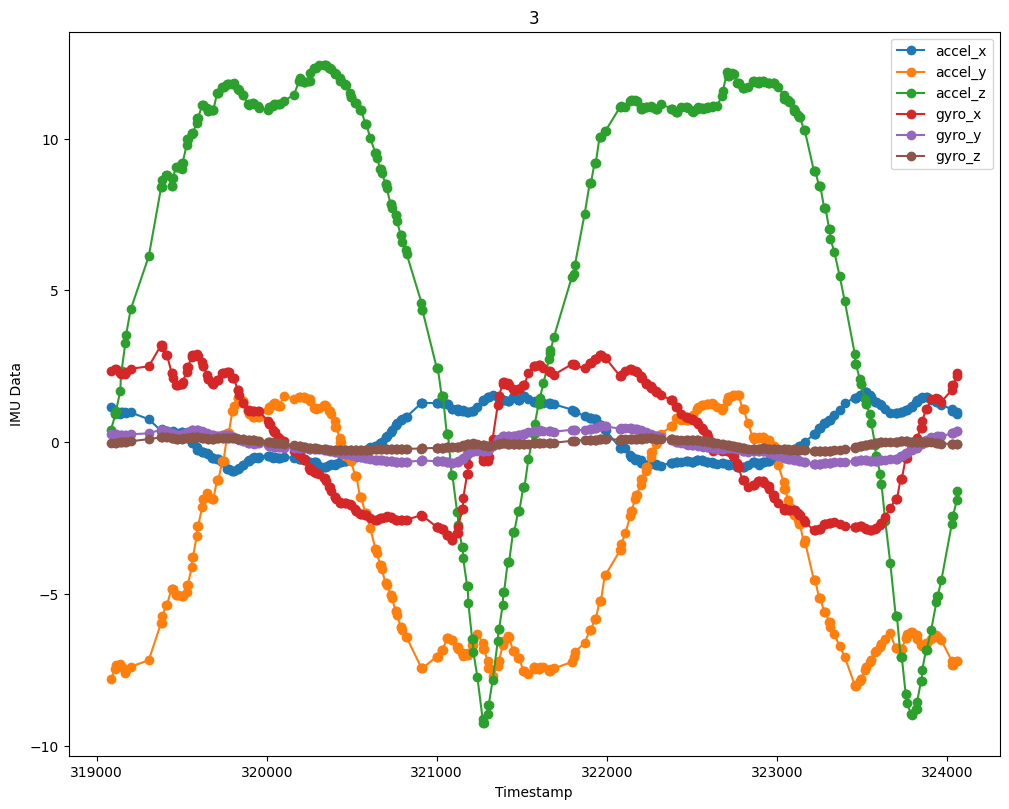

       timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z
0  319084.514286  1.145086 -7.796714  0.456143  2.349371  0.270914 -0.036771
1  319141.117460  0.965124 -7.361002  2.059197  2.243633  0.235403 -0.008702
2  319196.699856  0.959712 -7.496767  4.099369  2.346784  0.250453  0.027265
3  319388.649351  0.372420 -5.772020  8.631935  3.194689  0.412868  0.162370
4  319435.720346  0.341797 -4.935585  8.508019  2.411523  0.312930  0.139841


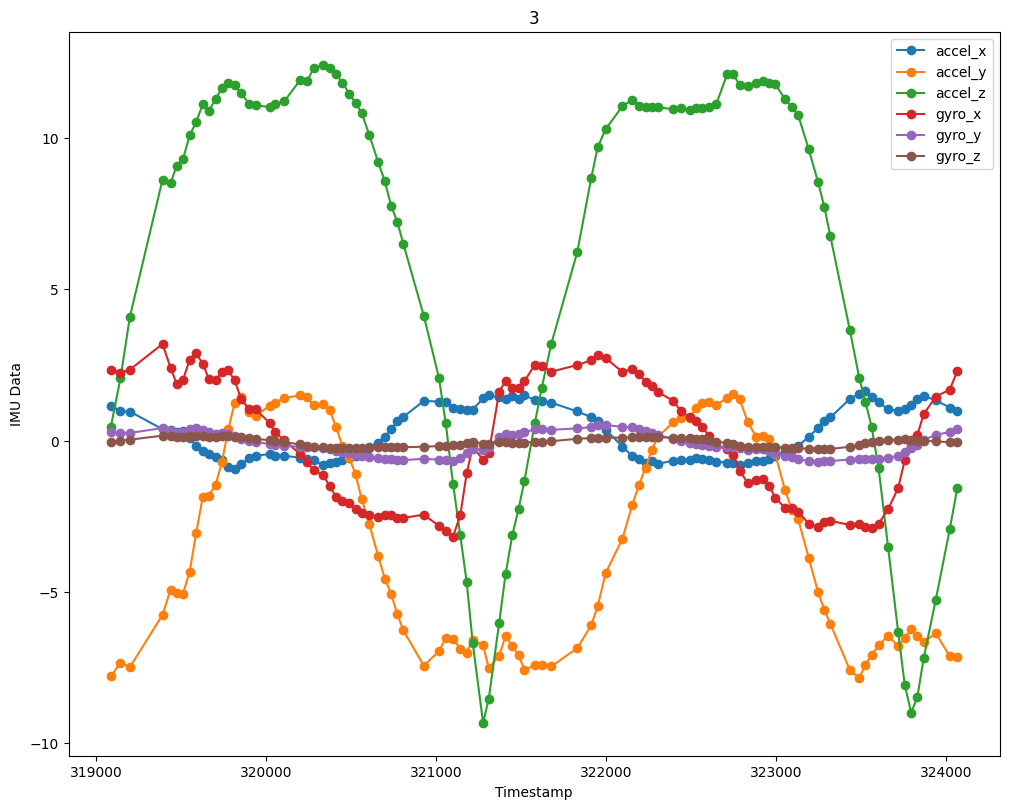

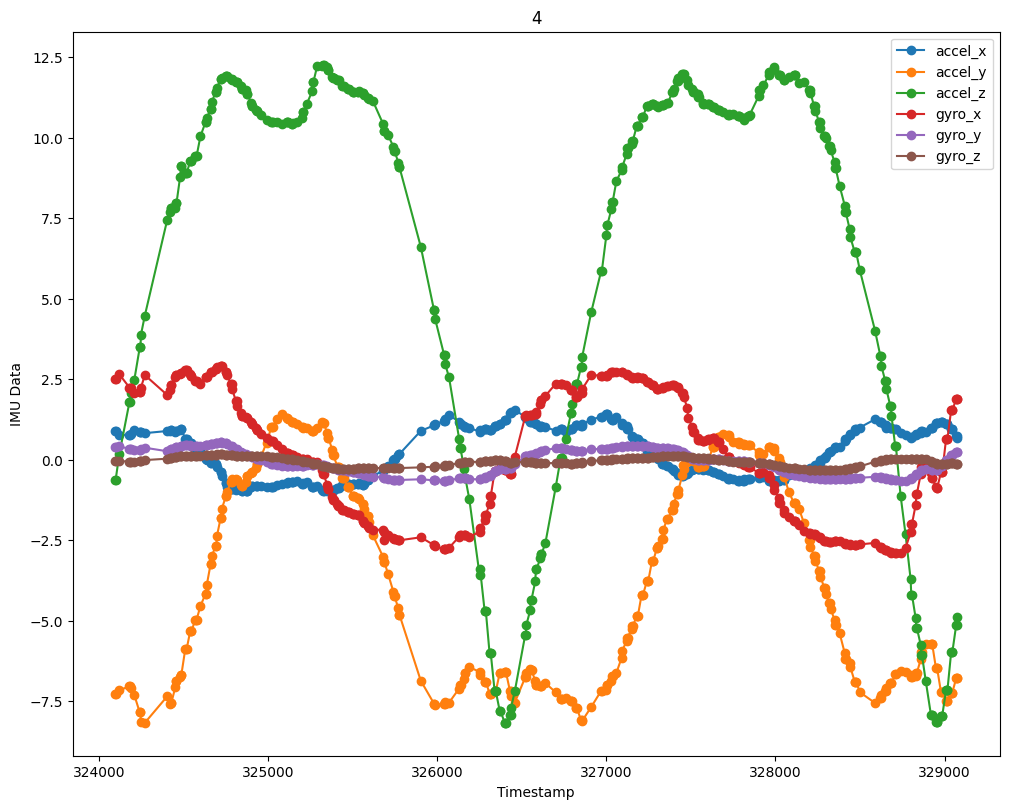

       timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z
0  324087.228571  0.919571 -7.305229 -0.847171  2.499200  0.411200 -0.042171
1  324178.793362  0.760186 -7.036845  1.763460  2.275257  0.339751 -0.060756
2  324236.911400  0.885975 -7.772802  3.331055  2.082202  0.303745 -0.056158
3  324364.696104  0.869471 -7.665480  6.579725  2.247661  0.305412  0.022754
4  324438.196537  0.901102 -7.301665  7.838672  2.449591  0.349235  0.076850


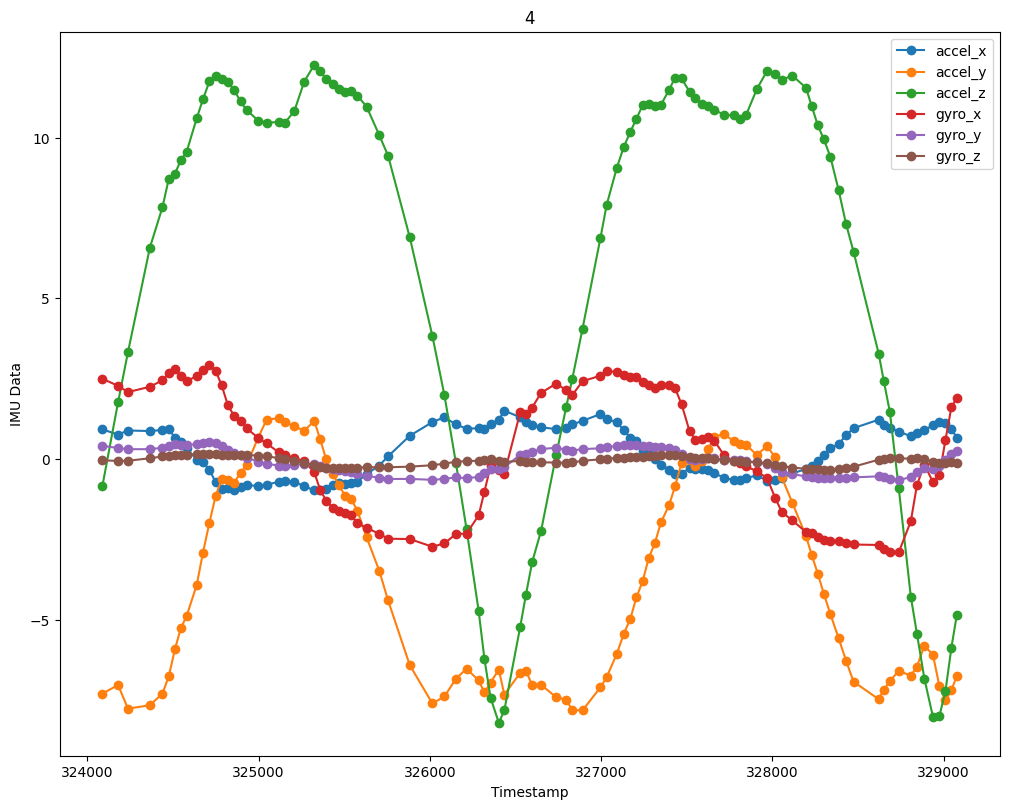

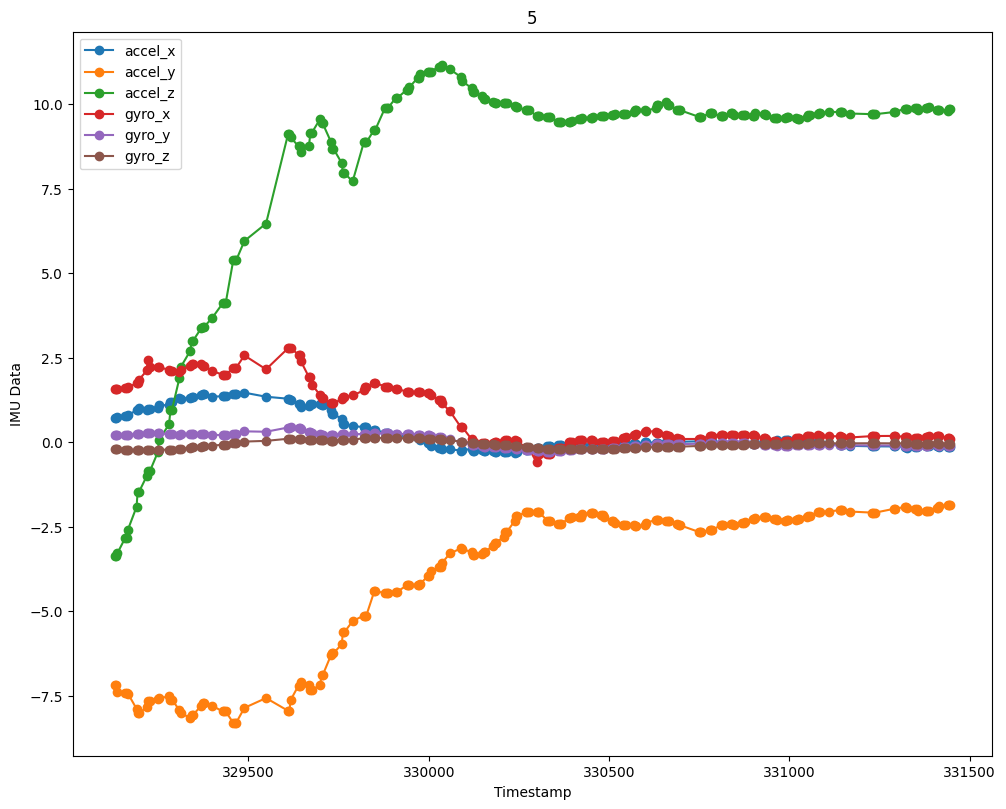

       timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z
0  329127.971429  0.705200 -7.160571 -3.409514  1.587200  0.218914 -0.195429
1  329141.546609  0.744978 -7.340419 -3.184294  1.590752  0.219076 -0.210692
2  329162.407504  0.790971 -7.391665 -2.780231  1.613184  0.225532 -0.227366
3  329184.119481  0.902938 -7.793259 -1.964201  1.706093  0.231895 -0.237707
4  329201.215007  0.986615 -7.993117 -1.320447  1.866818  0.251478 -0.235789


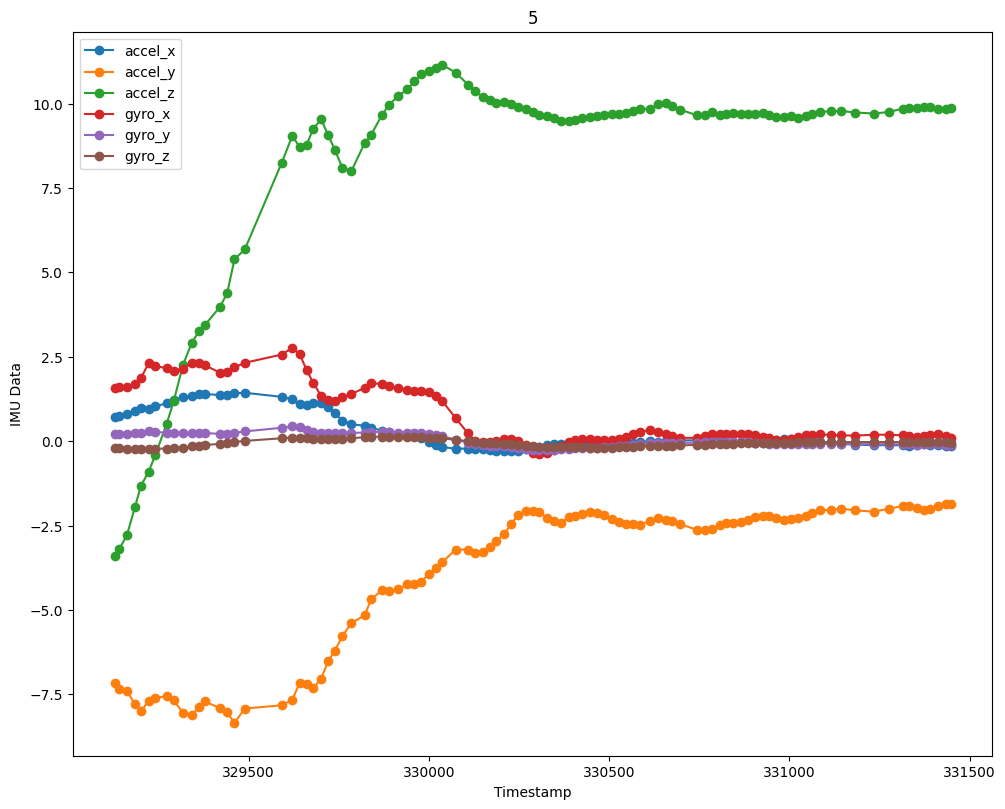

In [45]:
dfs = segment_df(df)
# print(dfs)

for i, df in enumerate(dfs):
    plot_df(df, i)
    df2 = smooth_and_resample(df, target_len=100, window_length=5)
    plot_df(df2, i)

In [46]:
X_train = []
X_test = []
y_train = []
y_test = []

for f, label in training_files.items():
    print(f"train: {f}")
    df = create_df(f)
    dfs = segment_df(df)
    n = len(dfs)
    for i, df in enumerate(dfs):
        if i == 0 or i == n - 1:
            continue
        df = smooth_and_resample(df, target_len=100)
        X_train.append(df)
        y_train.append(label)

for f, label in test_files.items():
    print(f"test: {f}")
    df = create_df(f)
    dfs = segment_df(df)
    n = len(dfs)
    for i, df in enumerate(dfs):
        if i == 0 or i == n - 1:
            continue
        df = smooth_and_resample(df, target_len=100)
        X_test.append(df)
        y_test.append(label)

y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"y_train: {y_train}")
print(f"y_test: {y_test}")

train: ../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     304079   -0.834    3.319    9.444   0.098  -0.054   0.012
1     304082   -0.824    3.326    9.452   0.098  -0.054   0.012
2     304085   -0.824    3.326    9.452   0.097  -0.053   0.012
3     304089   -0.824    3.326    9.452   0.097  -0.053   0.012
4     304110   -0.846    3.269    9.446   0.122  -0.056   0.007
       timestamp   accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z
0  309118.503497  1.119126 -7.329329 -1.233818  1.822734  0.238329 -0.066126
1  309161.361885  0.972058 -7.368590 -0.263453  2.049217  0.276893 -0.063326
2  309196.032328  0.888363 -7.372132  0.577386  2.210967  0.296441 -0.058686
3  309242.674083  0.883529 -7.412848  1.824048  2.518945  0.323230 -0.042429
4  309320.302442  0.897616 -7.081333  4.021360  2.596338  0.309848 -0.016636
       timestamp   accel_x   accel_y   accel_z   

In [47]:
X_train = np.array([df for df in X_train])
X_test = np.array([df for df in X_test])

X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

print(y_train)

num_classes = 5
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 4 4 4 4 4 3 3 3 3 3
 3 3]
X_train shape: (187, 100, 7)
y_train shape: (187, 5)
X_test shape: (163, 100, 7)
y_test shape: (163, 5)


In [48]:
# cnn_model = Sequential([
#     Input(shape=(X_train.shape[1], X_train.shape[2])),

#     # ---- BLOCK 1 ----
#     Conv1D(16, kernel_size=5, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),

#     # ---- BLOCK 2 ----
#     Conv1D(32, kernel_size=3, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),

#     # ---- GLOBAL POOL ----
#     GlobalAveragePooling1D(),

#     # ---- CLASSIFIER ----
#     Dense(32, activation='relu'),
#     Dropout(0.25),
#     Dense(num_classes, activation='softmax')
# ])
cnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(32, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    GlobalAveragePooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 96, 32)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 96, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 44, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 44, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,637 (178.27 KB)

 Trainable params: 45,189 (176.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [49]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2349 - loss: 1.8312 - val_accuracy: 0.0000e+00 - val_loss: 1.9871
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3691 - loss: 1.5037 - val_accuracy: 0.0000e+00 - val_loss: 1.8968
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3356 - loss: 1.5572 - val_accuracy: 0.0000e+00 - val_loss: 1.8855
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2886 - loss: 1.6292 - val_accuracy: 0.0000e+00 - val_loss: 2.1006
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2752 - loss: 1.6501 - val_accuracy: 0.0000e+00 - val_loss: 2.0540
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3356 - loss: 1.4480 - val_accuracy: 0.0000e+00 - val_loss: 1.9955
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2685 - loss: 1.6023 - val_accuracy: 0.0000e+00 - val_loss: 1.8903
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3758 - loss: 1.47

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

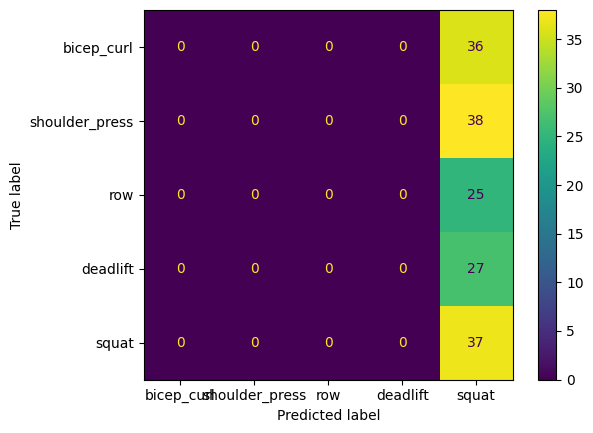

In [50]:
cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# cnn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()